## read lvd files and flatclust exported files

In [1]:
import numpy as np
import logging
import socket
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from importlib import reload
import scipy.io as sio

#from intan2kwik import kwd

#mountainsort imports (for sorting)
#import mountainlab_pytools.mlproc as mlp
from pipefinch.pipeline import sglxutil as sglu
from pipefinch.h5tools.kwik import event as ev
from pipefinch.pipeline import filestructure as et
from pipefinch.recorder.core import data as rd, setting as sd
from pipefinch.neural.postsort import session



# Setup the logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)
        
logger.info('Logger set')
logger.info('Hostname {}'.format(socket.gethostname()))

2019-09-14 15:54:55,403 - root - INFO - Logger set
2019-09-14 15:54:55,404 - root - INFO - Hostname lookfar


In [2]:
reload(et)

sess_par = {'bird': 'b11k10',
            'sess': '20190715_02',
           'probe': 'probe_0', # probe to sort ('probe_0', 'probe_1') (to lookup in the rig_par which port to extract)
           'sort': 1, 
           'epoch': None, # for the subfolder in the neuropix data}
           }

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sess_par['sort'])

# visualization default parameters
viz_par = { 'evt_name': 'motif',
           'evt_signal': 'trig_perceptron',
            'evt_edge': 1,
            'pre_ms': -500,
            'post_ms': 300,
            
            'pre_samples': 0,
            'post_samples': 0,
            'span': 0,
            }

# convenient paths
data_folder = os.path.join(exp_struct['folders']['bird'], 'Data')
meta_folder = os.path.join(exp_struct['folders']['bird'], 'MetaData')
set_folder = os.path.join(exp_struct['folders']['bird'], 'Settings')
data_days = et.list_subfolders(data_folder)

In [3]:
exp_struct

{'folders': {'bird': '/Volumes/Samsung_X5/microdrive/b11k10',
  'raw': '/Volumes/Samsung_X5/microdrive/b11k10/Ephys/raw/20190715_02',
  'kwik': '/Volumes/Samsung_X5/microdrive/b11k10/Ephys/kwik/20190715_02',
  'msort': '/Volumes/Samsung_X5/scratch/b11k10/Ephys/msort/20190715_02',
  'ksort': '/Volumes/Samsung_X5/scratch/b11k10/Ephys/ksort/20190715_02'},
 'files': {'par': '/Volumes/Samsung_X5/scratch/b11k10/Ephys/ksort/20190715_02/params.json',
  'set': '/Volumes/Samsung_X5/microdrive/b11k10/Ephys/raw/20190715_02/settings.isf',
  'rig': '/Volumes/Samsung_X5/microdrive/b11k10/Ephys/raw/20190715_02/rig.json',
  'kwd': '/Volumes/Samsung_X5/microdrive/b11k10/Ephys/kwik/20190715_02/stream.kwd',
  'kwik': '/Volumes/Samsung_X5/microdrive/b11k10/Ephys/kwik/20190715_02/sort_1/spikes.kwik',
  'kwe': '/Volumes/Samsung_X5/microdrive/b11k10/Ephys/kwik/20190715_02/events.kwe',
  'mda_raw': '/Volumes/Samsung_X5/scratch/b11k10/Ephys/msort/20190715_02/raw.mda',
  'bin_raw': '/Volumes/Samsung_X5/scratch/b

In [4]:
data_days[:5]

['2019-06-11-7060',
 '2019-06-12-7061',
 '2019-06-13-7062',
 '2019-06-14-7063',
 '2019-06-15-7064']

In [5]:
def get_day_files(data_folder, data_day):
    logger.info('getting files from day {}'.format(data_day))
    return glob.glob(os.path.join(data_folder, data_day, '*.lvd'))

def read_all_day(data_folder: str, data_day: str) -> (pd.DataFrame, pd.DataFrame):
    day_files = get_day_files(data_folder, data_day)
    day_files.sort()
    n_files = len(day_files)
    logger.info('Reading {} files'.format(n_files))
    days_df_list = list(map(rd.file_as_data_frame, day_files))
    logger.info('Done')
    day_df = pd.concat(days_df_list)
    
    # make a pandas with the timestamps of the beginning of all files
    logger.info('Getting timestamps of file beginnings')
    file_stamp_df = day_df.loc[day_df['file_sample']==0, ['file', 'time_stamp']].set_index('file')
    file_stamp_df.head()
    return day_df, file_stamp_df

def get_ttl_evt(day_df, chan=1, ev_name='glass', threshold=1000):
    # get on and offs of a 'ttl' event read as an analog chan
    logger.info('getting on/off stamps of event {} in channel {}'.format(ev_name, chan))
    day_df['ttl_{}_on'.format(ev_name)] = day_df.loc[:, chan].diff().gt(threshold)
    day_df['ttl_{}_off'.format(ev_name)] = day_df.loc[:, chan].diff().le(-threshold)
    return day_df

data_day = 1
day_files = get_day_files(data_folder, data_days[data_day])
set_files = glob.glob(os.path.join(set_folder, '*.txt'))

day_df, file_stamp_df = read_all_day(data_folder, data_days[data_day])
day_df = get_ttl_evt(day_df, 1, 'glass')
# stamp_day_df = day_df.set_index('abs_tstamp')

day_df.head()

2019-09-14 15:55:00,109 - root - INFO - getting files from day 2019-06-12-7061
2019-09-14 15:55:00,119 - root - INFO - getting files from day 2019-06-12-7061
2019-09-14 15:55:00,127 - root - INFO - Reading 2409 files
2019-09-14 15:55:22,360 - root - INFO - Done


,0,1,2,3,4,5,6,7,file_type,time_stamp,file,file_sample,ttl_glass_on,ttl_glass_off
0,1494,21598,0,0,241,-6557,0,21653,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,0,False,False
1,1491,21566,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,1,False,False
2,1490,21547,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,2,False,False
3,1489,21569,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,3,False,False
4,1492,21585,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,4,False,False


## Read masks/clusters

In [6]:
### reading the masks, clusters
def read_masks(meta_path, data_day) -> pd.DataFrame:
    masks_file = 'masks.mat'
    masks_f_path = os.path.join(meta_path, data_day, masks_file)
    masks_mat = sio.loadmat(masks_f_path)
    masks_df = pd.DataFrame({'file': masks_mat['files'].flatten(), 
                             'masks': masks_mat['masks'].flatten(),
                        'song': masks_mat['song'].flatten()})
    # clean up files field
    masks_df['file'] = masks_df['file'].apply(lambda x: np.array2string(x.squeeze()).strip('\'').split('.')[0])

    #clean up masks arrays
    masks_df['masks'] = masks_df['masks'].apply(np.squeeze)
    return masks_df



masks_df = read_masks(meta_folder,  data_days[data_day])
masks_df.head()

,file,masks,song
0,b11k10D-f00009,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[28972], [45618]]"
1,b11k10D-f00052,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[[]]
2,b11k10D-f00061,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[[]]
3,b11k10D-f00076,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[[]]
4,b11k10D-f00077,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[29185], [70501]]"


In [8]:
# read the clusters file
def read_clu_file(meta_folder, clu, data_day, prefix='song'):
    clu_file = '{}_C{}.txt'.format(prefix, clu)
    clu_pd = pd.read_csv(os.path.join(meta_folder, data_day, clu_file), sep='\t')
    clu_pd['filename'] = clu_pd['filename'].apply(lambda x: x.split('.')[0])
    clu_pd['clu'] = clu
    return clu_pd

clu_list = [2, 11]
clu_pd = pd.concat([read_clu_file(meta_folder, clu, data_days[data_day]) for clu in clu_list])
clu_pd.head()

,filename,segon,segoff,clu
0,b11k10D-f01765,50653,3699,2
1,b11k10D-f01587,88946,4664,2
2,b11k10D-f01947,29800,4567,2
3,b11k10D-f00154,88074,3892,2
4,b11k10D-f02286,30732,3942,2


In [9]:
clu_pd.groupby(['filename', 'clu']).head()


,filename,segon,segoff,clu
0,b11k10D-f01765,50653,3699,2
1,b11k10D-f01587,88946,4664,2
2,b11k10D-f01947,29800,4567,2
3,b11k10D-f00154,88074,3892,2
4,b11k10D-f02286,30732,3942,2
5,b11k10D-f00273,352707,4011,2
6,b11k10D-f00343,108714,3951,2
7,b11k10D-f00142,29748,4027,2
8,b11k10D-f01532,30127,4068,2
9,b11k10D-f01071,29101,3601,2


In [41]:
clu_pd.set_index(['filename', 'clu']).sort_values(['filename', 'segon'])

segon  segoff
filename       clu                
b11k10D-f00077 11   104106    1919
b11k10D-f00079 11    30730    2030
               11    99464    2145
               11   166660    1978
b11k10D-f00080 11    30798    2062
b11k10D-f00081 11    30677    2150
b11k10D-f00082 11    30857    1864
b11k10D-f00083 11    92463    2764
b11k10D-f00084 11    19220    1308
               11    23877    1368
               11    27508    1515
               11    31179    1529
               2     33538    4032
               11    67680    1305
               11    71128    1437
               2     73968   12538
b11k10D-f00085 11    30833    2155
b11k10D-f00086 11    30700    1923
b11k10D-f00088 11    27746    1501
               2     30512    3957
               11    55808    1415
               2     58380    4007
               2     81423    4126
               11   120256    1454
               2    122610    4063
               2    145626    4183
b11k10D-f00089 11    24663    1352
               11    27839    1467
               2     30283    4000
b11k10D-f00090 11    30773    2124
...                    ...     ...
b11k10D-f02291 11    27431    1626
               2     30519    3987
               11    57707    1551
               2     60228    4238
               2     83545    4694
b11k10D-f02299 11   306514    2092
b11k10D-f02309 2     95053    3670
b11k10D-f02314 11    85223    1483
b11k10D-f02331 11    30796    1939
b11k10D-f02359 11     6346    1328
               11    25787    1703
               2     28391    4170
               2     51308   15787
               2     74423    4015
               2     97814    4069
               11   118360    1459
               11   126990    1386
               2    129758    3996
               11   160957    1548
               11   168996    1377
               2    171718    4091
               2    194650    4192
               11   215794    1401
               11   234145    1906
               11   237391    1929
b11k10D-f02360 11     7898    1572
               11    21345    4849
               11    27823    1313
               2     30276    3939
b11k10U-f01035 11    30753    2240

[4168 rows x 2 columns]

## get the timestamps for the smartlgass events
the rest are left as they are to save time

In [6]:
s_f = 32000
ttl_select = day_df['ttl_glass_on'] | day_df['ttl_glass_on']

day_df.loc[ttl_select, 'delta_t'] = day_df.loc[ttl_select, 'file_sample'].apply(lambda x: pd.Timedelta(x/s_f, unit='s'))

day_df.loc[ttl_select, 'abs_t'] = day_df.loc[ttl_select, 'delta_t'] + day_df.loc[ttl_select, 'time_stamp']

In [7]:
day_df.loc[ttl_select].head()

,0,1,2,3,4,5,6,7,file_type,time_stamp,file,file_sample,ttl_glass_on,ttl_glass_off,delta_t,abs_t
31954,933,21584,0,0,0,0,0,0,Directed,2019-06-12 00:02:39.601600,b11k10D-f00002,31954,True,False,00:00:00.998562,2019-06-12 00:02:40.600162500
31948,618,21575,0,0,0,0,0,0,Directed,2019-06-12 00:11:53.218700,b11k10D-f00004,31948,True,False,00:00:00.998375,2019-06-12 00:11:54.217075000
31956,919,21561,0,0,0,0,0,0,Directed,2019-06-12 00:26:39.683600,b11k10D-f00006,31956,True,False,00:00:00.998625,2019-06-12 00:26:40.682225000
31984,129,21573,0,0,0,0,0,0,Directed,2019-06-12 00:39:18.757800,b11k10D-f00008,31984,True,False,00:00:00.999500,2019-06-12 00:39:19.757300000
31982,918,21597,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,31982,True,False,00:00:00.999437,2019-06-12 00:48:46.811937500


In [9]:
day_df_ttl = day_df.loc[ttl_select].set_index('abs_t')
day_df_ttl.head()

,0,1,2,3,4,5,6,7,file_type,time_stamp,file,file_sample,ttl_glass_on,ttl_glass_off,delta_t
abs_t,,,,,,,,,,,,,,,
2019-06-12 00:02:40.600162500,933,21584,0,0,0,0,0,0,Directed,2019-06-12 00:02:39.601600,b11k10D-f00002,31954,True,False,00:00:00.998562
2019-06-12 00:11:54.217075000,618,21575,0,0,0,0,0,0,Directed,2019-06-12 00:11:53.218700,b11k10D-f00004,31948,True,False,00:00:00.998375
2019-06-12 00:26:40.682225000,919,21561,0,0,0,0,0,0,Directed,2019-06-12 00:26:39.683600,b11k10D-f00006,31956,True,False,00:00:00.998625
2019-06-12 00:39:19.757300000,129,21573,0,0,0,0,0,0,Directed,2019-06-12 00:39:18.757800,b11k10D-f00008,31984,True,False,00:00:00.999500
2019-06-12 00:48:46.811937500,918,21597,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,31982,True,False,00:00:00.999437


## get all file start timestamps

In [11]:
day_df.head()

,0,1,2,3,4,5,6,7,file_type,time_stamp,file,file_sample,ttl_glass_on,ttl_glass_off,delta_t,abs_t
0,1494,21598,0,0,241,-6557,0,21653,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,0,False,False,NaT,NaT
1,1491,21566,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,1,False,False,NaT,NaT
2,1490,21547,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,2,False,False,NaT,NaT
3,1489,21569,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,3,False,False,NaT,NaT
4,1492,21585,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,4,False,False,NaT,NaT


In [91]:
#day_files.sort()
#day_files

,time_stamp
file,
b11k10D-f00001,2019-06-12 00:02:28.597700
b11k10D-f00002,2019-06-12 00:02:39.601600
b11k10D-f00003,2019-06-12 00:11:32.218700
b11k10D-f00004,2019-06-12 00:11:53.218700
b11k10D-f00005,2019-06-12 00:26:28.683600


In [13]:
day_df.head()

,0,1,2,3,4,5,6,7,file_type,time_stamp,file,file_sample,ttl_glass_on,ttl_glass_off,delta_t,abs_t
0,1494,21598,0,0,241,-6557,0,21653,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,0,False,False,NaT,NaT
1,1491,21566,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,1,False,False,NaT,NaT
2,1490,21547,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,2,False,False,NaT,NaT
3,1489,21569,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,3,False,False,NaT,NaT
4,1492,21585,0,0,0,0,0,0,Directed,2019-06-12 00:02:28.597700,b11k10D-f00001,4,False,False,NaT,NaT


## read single file

In [25]:
reload(sd)
reload(rd)

day_file, day_hdr, day_meta = rd.read_file(day_files[0])

day_df = rd.file_as_data_frame(day_files[0])
set_dict = sd.read_settings_file(set_files[4])

Done reading


/home/ezequiel/repos/pipefinch/pipefinch/recorder/core/setting.py:79: UserWarning: Failed to parse key: val reading recorder processor settings line {save level true\\

  'Failed to parse key: val reading recorder processor settings line {}'.format(line))
/home/ezequiel/repos/pipefinch/pipefinch/recorder/core/setting.py:79: UserWarning: Failed to parse key: val reading recorder processor settings line {save level false\\

  'Failed to parse key: val reading recorder processor settings line {}'.format(line))


In [26]:
day_df.head()

,0,1,2,3,4,5,6,7,file_type,time_stamp,file,file_sample
0,962,460,0,0,218,-6557,0,480,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,0
1,968,467,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,1
2,970,463,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,2
3,965,459,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,3
4,963,460,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,4


In [7]:
day_df['file_sample'] = day_df.index

In [8]:
day_df.head()

,0,1,2,3,4,5,6,7,file_type,time_stamp,file,abs_tstamp,file_sample
0,962,460,0,0,218,-6557,0,480,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,2019-06-12 00:48:45.812500,0
1,968,467,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,2019-06-12 00:48:45.812531,1
2,970,463,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,2019-06-12 00:48:45.812562,2
3,965,459,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,2019-06-12 00:48:45.812594,3
4,963,460,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,2019-06-12 00:48:45.812625,4


In [70]:
day_df.set_index('abs_tstamp')

,0,1,2,3,4,5,6,7,file_type,time_stamp,file
abs_tstamp,,,,,,,,,,,
2019-06-12 00:48:45.812500,962,460,0,0,218,-6557,0,480,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011
2019-06-12 00:48:45.812531,968,467,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011
2019-06-12 00:48:45.812562,970,463,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011
2019-06-12 00:48:45.812594,965,459,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011
2019-06-12 00:48:45.812625,963,460,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011
2019-06-12 00:48:45.812656,962,464,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011
2019-06-12 00:48:45.812688,965,463,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011
2019-06-12 00:48:45.812719,966,458,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011
2019-06-12 00:48:45.812750,966,459,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011


In [73]:
day_df.head()

,0,1,2,3,4,5,6,7,file_type,time_stamp,file,abs_tstamp
0,962,460,0,0,218,-6557,0,480,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,2019-06-12 00:48:45.812500
1,968,467,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,2019-06-12 00:48:45.812531
2,970,463,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,2019-06-12 00:48:45.812562
3,965,459,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,2019-06-12 00:48:45.812594
4,963,460,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,2019-06-12 00:48:45.812625


In [62]:
day_df.index.apply(abs)

AttributeError: 'RangeIndex' object has no attribute 'apply'

In [59]:
[datetime.timedelta(seconds=x) for x in day_df.index.values/32000]

[datetime.timedelta(0),
 datetime.timedelta(0, 0, 31),
 datetime.timedelta(0, 0, 62),
 datetime.timedelta(0, 0, 94),
 datetime.timedelta(0, 0, 125),
 datetime.timedelta(0, 0, 156),
 datetime.timedelta(0, 0, 188),
 datetime.timedelta(0, 0, 219),
 datetime.timedelta(0, 0, 250),
 datetime.timedelta(0, 0, 281),
 datetime.timedelta(0, 0, 312),
 datetime.timedelta(0, 0, 344),
 datetime.timedelta(0, 0, 375),
 datetime.timedelta(0, 0, 406),
 datetime.timedelta(0, 0, 438),
 datetime.timedelta(0, 0, 469),
 datetime.timedelta(0, 0, 500),
 datetime.timedelta(0, 0, 531),
 datetime.timedelta(0, 0, 562),
 datetime.timedelta(0, 0, 594),
 datetime.timedelta(0, 0, 625),
 datetime.timedelta(0, 0, 656),
 datetime.timedelta(0, 0, 688),
 datetime.timedelta(0, 0, 719),
 datetime.timedelta(0, 0, 750),
 datetime.timedelta(0, 0, 781),
 datetime.timedelta(0, 0, 812),
 datetime.timedelta(0, 0, 844),
 datetime.timedelta(0, 0, 875),
 datetime.timedelta(0, 0, 906),
 datetime.timedelta(0, 0, 938),
 datetime.timedelta

In [63]:
day_df['abs_tstamp'] = day_df['time_stamp'] + pd.Series([datetime.timedelta(seconds=x) for x in day_df.index.values/32000])

In [64]:
day_df

,0,1,2,3,4,5,6,7,file_type,time_stamp,file,abs_tstamp
0,962,460,0,0,218,-6557,0,480,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,2019-06-12 00:48:45.812500
1,968,467,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,2019-06-12 00:48:45.812531
2,970,463,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,2019-06-12 00:48:45.812562
3,965,459,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,2019-06-12 00:48:45.812594
4,963,460,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,2019-06-12 00:48:45.812625
5,962,464,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,2019-06-12 00:48:45.812656
6,965,463,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,2019-06-12 00:48:45.812688
7,966,458,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,2019-06-12 00:48:45.812719
8,966,459,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,2019-06-12 00:48:45.812750
9,968,458,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,2019-06-12 00:48:45.812781


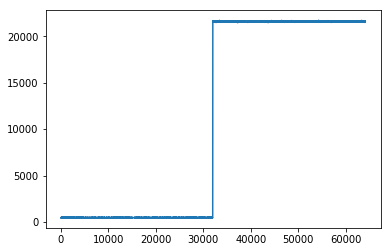

In [37]:
plt.plot(day_df.loc[:, 1])

In [43]:
day_df['ttl_glass_on'] = day_df.loc[:, 1].diff().gt(10000)
day_df['ttl_glass_on'] = day_df.loc[:, 1].diff().le(10000)

In [44]:
day_df.head()

,0,1,2,3,4,5,6,7,file_type,time_stamp,file,ttl_glass_on
0,962,460,0,0,218,-6557,0,480,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,False
1,968,467,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,False
2,970,463,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,False
3,965,459,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,False
4,963,460,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500,b11k10D-f00011,False


In [122]:
import pandas as pd

In [155]:
day_df

,0,1,2,3,4,5,6,7,file_type,time_stamp
0,962,460,0,0,218,-6557,0,480,Directed,2019-06-12 00:48:45.812500
1,968,467,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500
2,970,463,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500
3,965,459,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500
4,963,460,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500
5,962,464,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500
6,965,463,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500
7,966,458,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500
8,966,459,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500
9,968,458,0,0,0,0,0,0,Directed,2019-06-12 00:48:45.812500


In [118]:
reload(rd)
meta_dict = rd.read_meta_file(day_files[0])
meta_dict

{'file_type': 'Directed',
 'time_stamp': datetime.datetime(2019, 6, 12, 0, 48, 45, 812500)}

In [104]:
lines_arr = np.array([z.split('\n')[0].strip() for z in file_lines])
lines_arr

array(['filetype:', '{', 'Directed', '}', '', '', 'thresholds activators',
       '{', '2.000000,', '0.500000,', '1.000000,', '2.000000,', '}', '',
       '~D0{}', '', '~D1{}', '', '~D2{}', '', '~D3{}', '', '~D4{}', '',
       '~D5{}', '', '~D6{}', '', '~D7{}', '', '~A0{}', '', '~A1{}', '',
       '~A2{}', '', '~A3{}', '', '~E0{}', '', '~E1{}', '', '*',
       '20190612004845.812500', '*', '+', '501', '+', '', '---', '',
       '3#{250|250|}%{0}${0.035775^0.000000^-1.000583^0.000000^-1.000583^0.000000^-1.000568^3.302421}&{0^0}'],
      dtype='<U99')

In [111]:
t_stamp = lines_arr[np.where(lines_arr=='*')[0] + 1][0]
t_stamp

'20190612004845.812500'

In [112]:
from datetime import datetime

In [114]:
t_obj = datetime.strptime(t_stamp, '%Y%m%d%H%M%S.%f')
t_obj

datetime.datetime(2019, 6, 12, 0, 48, 45, 812500)

In [96]:
fpath = '/mnt/microdrive/birds/b11k10/Data/2019-06-12-7061/Meta/b11k10D-f00011.txt'
with open(fpath, 'r') as fid:
    flines = fid.readlines()
flines

['filetype: \n',
 '{\n',
 'Directed\n',
 '}\n',
 '\n',
 '\n',
 'thresholds activators \n',
 '{\n',
 '2.000000,\n',
 '0.500000,\n',
 '1.000000,\n',
 '2.000000,\n',
 '}\n',
 '\n',
 '~D0{}\n',
 '\n',
 '~D1{}\n',
 '\n',
 '~D2{}\n',
 '\n',
 '~D3{}\n',
 '\n',
 '~D4{}\n',
 '\n',
 '~D5{}\n',
 '\n',
 '~D6{}\n',
 '\n',
 '~D7{}\n',
 '\n',
 '~A0{}\n',
 '\n',
 '~A1{}\n',
 '\n',
 '~A2{}\n',
 '\n',
 '~A3{}\n',
 '\n',
 '~E0{}\n',
 '\n',
 '~E1{}\n',
 '\n',
 '*\n',
 '20190612004845.812500\n',
 '*\n',
 '+\n',
 '501\n',
 '+\n',
 '\n',
 '---\n',
 '\n',
 '3#{250|250|}%{0}${0.035775^0.000000^-1.000583^0.000000^-1.000583^0.000000^-1.000568^3.302421}&{0^0}\n']

In [94]:
file_lines

In [84]:
day_files[0]

'/mnt/microdrive/birds/b11k10/Data/2019-06-12-7061/b11k10D-f00011.lvd'

In [81]:
set_dict

{'hostname': ('ZUFURIOUS',),
 'principal investigator': ('Corinna',),
 'birdname': ('b11k10',),
 'setup': ('ParisE8',),
 'channels': ('PXI1Slot2/ai0',
  'PXI1Slot2/ai1',
  'PXI1Slot2/ao0',
  'PXI1Slot2/ao1'),
 'buffersize': ('128',),
 'scanrate': ('32000.000000',),
 'dynamic range': ('5.000000',),
 'pre [s]': ('1.000000',),
 'post [s]': ('1.000000',),
 'timestamp': ('20190611161058.010',),
 'channel info': ('ParisE8, mic_e8, save true, gain 1.000000',
  'ParisE8, ttl_smartglass, save true, gain 1.000000',
  'ParisE8, trig_rec_e8, save true, gain 1.000000',
  'ParisE8, trig_perc_e8, save true, gain 1.000000'),
 'detector': ({'class': ' detector_harmonics2',
   'name': ' det_harm_e8',
   'AI indices': ' [0||]',
   'note': ' ',
   'meta file parameters': ' '},
  {'class': ' detector_pitch',
   'name': ' det_pitch_e8',
   'AI indices': ' [0||]',
   'note': ' energy minimum: 0.200000, expected pitch: 700.000000, subsample factor: 9.000000',
   'meta file parameters': ' '},
  {'class': ' det

In [68]:
day_hdr

{'hdr_size': 32, 'n_channels': 8, 'sample_rate': 32000.0, 'dynamic_range': 5.0}

In [69]:
day_file.shape

(64128, 8)

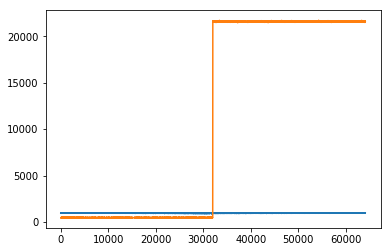

In [70]:
plt.plot(day_file[:, 0])
plt.plot(day_file[:, 1])

In [48]:
pd.DataFrame

NameError: name 'pd' is not defined

In [64]:
day_file.shape[0]/32000

2.5

In [ ]:
# get list of all data files

In [6]:
data_folder

'/mnt/microdrive/birds/g4r4/Data'